<a href="https://colab.research.google.com/github/sumankmaiti/NIP-Neuron-Label-Inverse-Perturbation/blob/main/NIP_pytorch_trial5_next_neuron_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cleverhans

     |████████████████████████████████| 92 kB 138 kB/s 
     |████████████████████████████████| 154 kB 36.1 MB/s 
     |████████████████████████████████| 42 kB 706 kB/s 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from torch.nn.functional import normalize

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import glob
import torch
from torch.utils.data import Dataset, DataLoader
from skimage import io

from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

# from absl import app, flags
# from easydict import EasyDict
import torchvision
from google.colab.patches import cv2_imshow
import cv2

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent,
)

In [ ]:
import torchvision.models as models

pretrained_model = models.vgg19(pretrained=True)

for param in pretrained_model.classifier[0].parameters():
    param.requires_grad = True

# pretrained_model_adv =  pretrained_model
print(pretrained_model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]

# train_transforms = transforms.Compose([
#                            transforms.Resize(pretrained_size),
#                            transforms.RandomRotation(5),
#                            transforms.RandomHorizontalFlip(0.5),
#                            transforms.RandomCrop(pretrained_size, padding=10),
#                            transforms.ToTensor(),
#                            transforms.Normalize(mean=pretrained_means,
#                                                 std=pretrained_stds)
                      #  ])

test_transforms = transforms.Compose([
                          # transforms.ToPILImage(),
                          transforms.ToTensor(),
                          transforms.Resize([pretrained_size, pretrained_size]),
                          #  transforms.Normalize(mean=pretrained_means,
                                                # std=pretrained_stds)
                       ])

In [ ]:
# ROOT = '.data'

# # train_data = datasets.CIFAR10(ROOT,
# #                               train=True,
# #                               download=True,
# #                               transform=train_transforms)

# test_data = datasets.CIFAR10(ROOT,
#                              train=False,
#                              download=True,
#                              transform=test_transforms)

# # print(f'Number of training examples: {len(train_data)}')
# # print(f'Number of validation examples: {len(valid_data)}')
# print(f'Number of testing examples: {len(test_data)}')

Files already downloaded and verified
Number of testing examples: 10000


-------------------------------------------------- Class for Making custom dataset from image folder ------------------------------------------------------------

Option 1

In [ ]:
data = torchvision.datasets.ImageFolder("/content/drive/MyDrive/IMAGENET/", transform  =  test_transforms)

Option 2

In [ ]:
class ImagenetImages(Dataset):
    def __init__(self, transform=None):
        self.imgs_path = "/content/drive/MyDrive/IMAGENET/"
        self.transform = transform
        
        file_list = glob.glob(self.imgs_path + "*")
        print(file_list)
        
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "/*.JPEG"):
                # self.data.append([img_path, class_name])
                self.data.append(img_path)
        
        print(self.data)
        # self.class_map = {"dogs" : 0, "cats": 1}
        # self.img_dim = (416, 416)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = io.imread(img_path)
        # img = cv2.resize(img, self.img_dim)
        # class_id = self.class_map[class_name]
        # img_tensor = torch.from_numpy(img)
        # img_tensor = img_tensor.permute(2, 0, 1)
        if self.transform:
            img_tensor = self.transform(image)
        # class_id = torch.tensor([class_id])
        # return img_tensor, class_id
        return img_tensor

In [ ]:
imagenet_data = ImagenetImages(transform = test_transforms)
# dataset.transform = test_transforms

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
BATCH_SIZE = 1

# train_iterator = data.DataLoader(train_data,
#                                  shuffle=True,
#                                  batch_size=BATCH_SIZE)

# valid_iterator = data.DataLoader(valid_data,
#                                  batch_size=BATCH_SIZE)

test_iterator = DataLoader(data,
                                batch_size=BATCH_SIZE)

In [ ]:
for imgs, lebel in test_iterator:
    print("Batch of images has shape: ",lebel)

In [ ]:
# for i in range(len(test_iterator)):
#   print(test_iterator[i])
# print(len(test_iterator))

0


In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Store the output of a layer

In [ ]:
# collect output of a layer https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
# criterion = nn.CrossEntropyLoss()
# criterion.to(device)

CrossEntropyLoss()

Real image given to the model -----------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Evaluate on clean and adversarial data
pretrained_model.eval().to(device)

real_img = []
activation_flat_real=[]
predected_labels = []
gradient_flat_real = []

count = 0
# for (x, y) in tqdm(test_iterator):
for x, y in tqdm(test_iterator):

  if count<1:
      x, y = x.to(device), y.to(device)
      # x = x.to(device)

      real_img.append(x)

      # collect output of flatten layer for real images
      pretrained_model.classifier[0].register_forward_hook(get_activation('flatten'))

      # give original image to the model
      y_pred = pretrained_model(x)  # model prediction on clean examples
      # print(y_pred)
      
      activation_flat_real.append(activation['flatten'])
      # activation['flatten'] = 0
      print("activation",activation['flatten'])

      y_pred = F.softmax(y_pred, dim=-1) # column wise softmax
      # print(y_pred.shape)
      prob, y_class = y_pred.max(1)
      # print("Predected probability:",prob)
      
      # get gradient of flatten layer for real images
      # loss_r = criterion(y_pred, y)
      prob.backward()  # https://www.tutorialspoint.com/what-does-backward-do-in-pytorch
      
      flatten_layer_grad_real = pretrained_model.classifier[0].weight.grad
      # print("grad shape before sum:",flatten_layer_grad_real.shape)
      
      # gradient for a single neuron
      flatten_layer_grad_real = flatten_layer_grad_real.sum(1)
      gradient_flat_real.append(flatten_layer_grad_real)

      # print("grad shape after sum:", flatten_layer_grad_real.shape)
      
      # setting gradient 0 for next iteraton
      pretrained_model.classifier[0].weight.grad.data.zero_()

      predected_labels.append(y_class)

      print("shape of activation:", len(activation_flat_real), len(activation_flat_real[0][0]))    

      print("shape of grads:", len(gradient_flat_real), len(gradient_flat_real[0]))

      # print(gradient_flat_real)
      
      count = count + 1
  else:
      break

real_img = torch.cat(real_img, dim=0)
predected_labels = torch.cat(predected_labels, dim=0)
activation_flat_real= torch.cat(activation_flat_real, dim=0)
gradient_flat_real = torch.stack(gradient_flat_real)

  0%|          | 0/104 [00:00<?, ?it/s]

activation tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
shape of activation: 1 4096
shape of grads: 1 4096


In [ ]:
print(activation_flat_real.shape)
print(predected_labels.shape)
print(gradient_flat_real.shape)

torch.Size([100, 4096])
torch.Size([100])
torch.Size([100, 4096])


-------------------------------------------------------------------------------------------------------------------------------------

Perturbed image given to the model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Evaluate on clean and adversarial data
pretrained_model.eval().to(device)

activation_flat_adv=[]
adv_img = []
adv_labels = []
gradient_flat_adv = []

count = 0
for (x, y) in tqdm(test_iterator):
# for x in tqdm(test_iterator):

  if count<1:
      x, y = x.to(device), y.to(device)

      # pertured images
      x_fgm = fast_gradient_method(pretrained_model, x, 0.5,2)
      adv_img.append(x_fgm)

      # x_fgm = projected_gradient_descent(pretrained_model, x, 0.3, 0.01, 50, 2)
      # adv_img.append(x_fgm)

      # collect output of flatten layer for adv images
      pretrained_model.classifier[0].register_forward_hook(get_activation('flatten_adv'))

      #  collect output of flatten layer for adv images
      y_pred_fgm = pretrained_model(x_fgm)  # model prediction on FGM adversarial examples
      activation_flat_adv.append(activation['flatten_adv'])

      y_pred_fgm = F.softmax(y_pred_fgm, dim=-1) # column wise softmax
      # print(y_pred_fgm.shape)
      prob_adv, y_class_adv = y_pred_fgm.max(1)
      # print("Predected probability:",prob_adv)
     
      # get gradient of flatten layer for adv images
      # loss_r = criterion(y_pred, y)
      prob_adv.backward()  # https://www.tutorialspoint.com/what-does-backward-do-in-pytorch
      
      flatten_layer_grad_adv = pretrained_model.classifier[0].weight.grad
      # print("grad shape before sum:",flatten_layer_grad_adv.shape)
      
      # gradient for a single neuron
      flatten_layer_grad_adv = flatten_layer_grad_adv.sum(1)
      gradient_flat_adv.append(flatten_layer_grad_adv)

      # print("grad shape after sum:", flatten_layer_grad_adv.shape)
      
      # setting gradient 0 for next iteraton
      pretrained_model.classifier[0].weight.grad.data.zero_()

      adv_labels.append(y_class_adv)

      print("shape of activation:", len(activation_flat_adv), len(activation_flat_adv[0][0]))    

      print("shape of grads:", len(gradient_flat_adv), len(gradient_flat_adv[0]))

      count = count + 1
  else:
      break
adv_img = torch.cat(adv_img, dim = 0)
adv_labels = torch.cat(adv_labels, dim = 0)
activation_flat_adv=torch.cat(activation_flat_adv, dim=0)
gradient_flat_adv = torch.stack(gradient_flat_adv)

  0%|          | 0/104 [00:00<?, ?it/s]

shape of activation: 1 4096
shape of grads: 1 4096


----------------------------------------------------------------------------------------------------------------

View some sample images with predictions ------------------------------------------------------------------------------------------------------------------------------------

original image

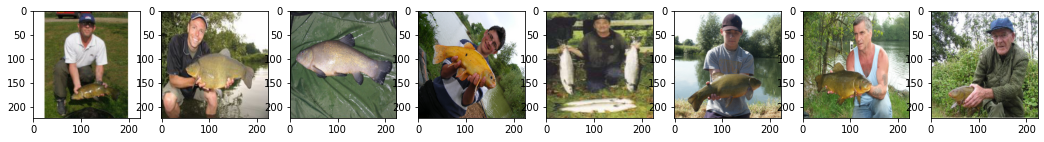

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

X = list(int(i) for i in range(0, 512))

# Initialize the lists for X and Y

columns = 8
rows = 1
fig = plt.figure(figsize=(18,18))
for i in range(1, columns*rows + 1):
    img = real_img[i-1].permute(1, 2, 0)
    img = img.cpu().detach().numpy()
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()
# plt.xticks(rotation = 0)
    # plt.savefig('dataset_and_generated_graph/same_resolution/plot'+str(i)+'.png', dpi=500, bbox_inches='tight')

perturbed image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


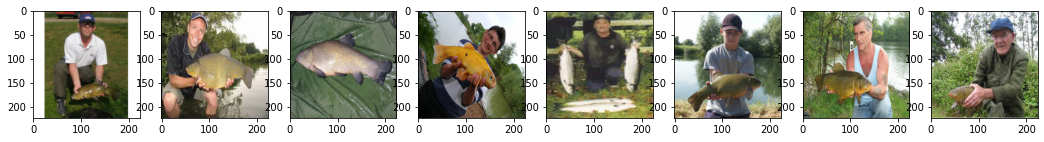

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

X = list(int(i) for i in range(0, 512))

# Initialize the lists for X and Y

columns = 8
rows = 1
fig = plt.figure(figsize=(18,18))
for i in range(1, columns*rows + 1):
    img = adv_img[i-1].permute(1, 2, 0)
    img = img.cpu().detach().numpy()
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()
# plt.xticks(rotation = 0)
    # plt.savefig('dataset_and_generated_graph/same_resolution/plot'+str(i)+'.png', dpi=500, bbox_inches='tight')

In [ ]:
print("predected classes on real images", predected_labels)
print("predected classes on adv images", adv_labels)

predected classes on real images tensor([394])
predected classes on adv images tensor([899])


----------------------------------------------------------------------------------------------------------------

Neuron activations for real and perturbed images -------------------------------------------------------------------------------------------------------------------------------

In [ ]:
print(activation_flat_adv.shape)

torch.Size([100, 4096])


In [ ]:
activation_flat_real = normalize(activation_flat_real, dim = 1)
activation_flat_adv = normalize(activation_flat_adv, dim = 1)

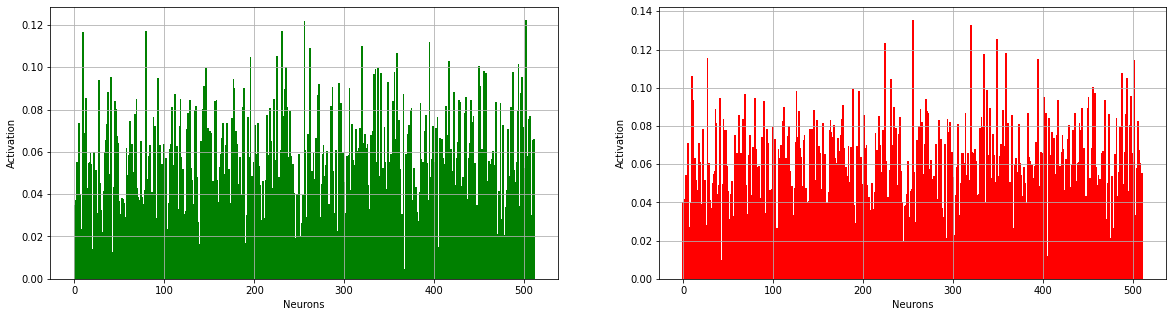

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

X = list(int(i) for i in range(0, 512))

# Initialize the lists for X and Y

fig, axs = plt.subplots(1, 2, figsize=(20,5))

axs[0].set_xlabel("Neurons")
axs[0].set_ylabel("Activation")
axs[1].set_xlabel("Neurons")
axs[1].set_ylabel("Activation")

axs[0].grid()
axs[1].grid()

for i in range(100):
  
  axs[0].bar(X, activation_flat_real[i][0:512].cpu(), color = 'g', width=2)
  axs[1].bar(X, activation_flat_adv[i][0:512].cpu(), color = 'r', width=2)

# plt.xticks(rotation = 0)
    # plt.savefig('dataset_and_generated_graph/same_resolution/plot'+str(i)+'.png', dpi=500, bbox_inches='tight')
plt.show()

-----------------------------------------------------------------------------------------------------------------------------------------------

Gradients of the neurons -------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# gradient_flat_real = abs(gradient_flat_real)
# gradient_flat_adv = abs(gradient_flat_adv)

gradient_flat_real = normalize(gradient_flat_real, dim = 1)
gradient_flat_adv = normalize(gradient_flat_adv, dim = 1)

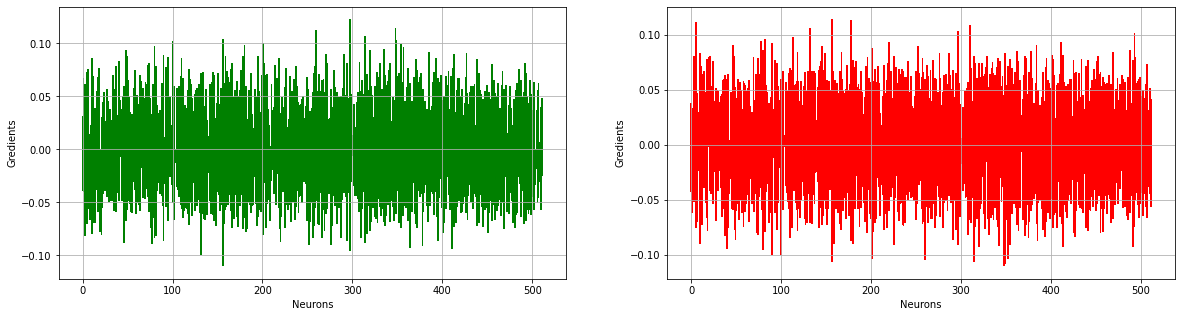

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

X = list(int(i) for i in range(0, 512))

# Initialize the lists for X and Y

fig, axs = plt.subplots(1, 2, figsize=(20,5))

axs[0].set_xlabel("Neurons")
axs[0].set_ylabel("Gredients")
axs[1].set_xlabel("Neurons")
axs[1].set_ylabel("Gredients")

axs[0].grid()
axs[1].grid()

# plt.xlim(-0.5, 50)
# plt.ylim(-0.5, 5)
for i in range(100):
  
  axs[0].bar(X, gradient_flat_real[i][0:512].cpu(), color = 'g', width=2)
  axs[1].bar(X, gradient_flat_adv[i][0:512].cpu(), color = 'r', width=2)

# plt.xticks(rotation = 0)
    # plt.savefig('dataset_and_generated_graph/same_resolution/plot'+str(i)+'.png', dpi=500, bbox_inches='tight')
plt.show()

------------------------------------------------------------------------------------------------------------------------------

Influence of neurons -------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
print(activation_flat_real.shape, activation_flat_adv.shape)
print(gradient_flat_real.shape, gradient_flat_adv.shape)

influence_real = activation_flat_real * gradient_flat_real
influence_adv = activation_flat_adv * gradient_flat_adv

print(influence_real.shape)
print(influence_adv.shape)

torch.Size([50, 4096]) torch.Size([50, 4096])
torch.Size([50, 4096]) torch.Size([50, 4096])
torch.Size([50, 4096])
torch.Size([50, 4096])


Influence graph

In [ ]:
# influence_real = abs(influence_real)
# influence_adv = abs(influence_adv)

influence_real = normalize(influence_real, dim=1)
influence_adv = normalize(influence_adv,  dim=1)

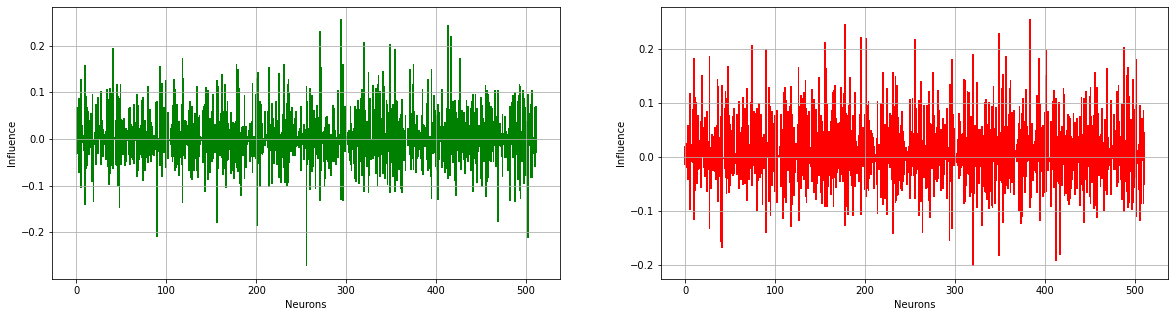

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

X = list(int(i) for i in range(0, 512))

# Initialize the lists for X and Y
fig, axs = plt.subplots(1, 2, figsize=(20,5))

axs[0].set_xlabel("Neurons")
axs[0].set_ylabel("Influence")
axs[1].set_xlabel("Neurons")
axs[1].set_ylabel("Influence")

axs[0].grid()
axs[1].grid()

# plt.xlim(-0.5, 50)
# plt.ylim(-0.5, 5)
for i in range(100):
  
  axs[0].bar(X, influence_real[i,0:512].cpu(), color = 'g', width=2)
  axs[1].bar(X, influence_adv[i,0:512].cpu(), color = 'r', width=2)

# plt.xticks(rotation = 0)
    # plt.savefig('dataset_and_generated_graph/same_resolution/plot'+str(i)+'.png', dpi=500, bbox_inches='tight')
plt.show()

------------------------------------------------------------------------------------------------------------------------

In [ ]:
# we would have to consider for one particular class images then the graph will be more significant because for that calss neuron activation will be different for real and imaginary

View selected Neurons for real and perturbed images --------------------------------------------------------------------------------------------------------------------

In [ ]:
# Neuron Output
sorted_real, indices = torch.sort(activation_flat_real, descending=True, dim = 1)
print(sorted_real.shape)
print(indices)
# Neuron influence

torch.Size([50, 4096])
tensor([[3602, 2495, 1191,  ..., 1631, 1632, 1634],
        [3357,  502, 3270,  ..., 1605, 1606, 1608],
        [3292, 2626, 1681,  ..., 1592, 1593, 1594],
        ...,
        [ 225, 2626,  980,  ..., 1567, 1568, 1570],
        [1766, 3780, 3415,  ..., 1598, 1599, 1601],
        [1464, 3774,  196,  ..., 1596, 1597, 1598]])


In [ ]:
tmp = []
for i in range(len(indices)):
  # print(sorted_real[i])
  val = []
  for j in indices[i]:
    value = activation_flat_adv[i][j]
    val.append(value)
  # print(val)  
  tmp.append(torch.FloatTensor(val))
# print(tmp)

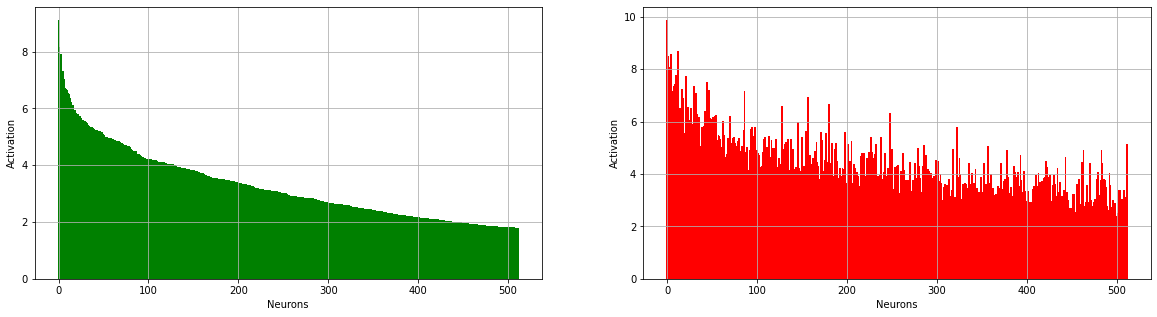

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

X = list(int(i) for i in range(0, 512))

# Initialize the lists for X and Y

fig, axs = plt.subplots(1, 2, figsize=(20,5))

axs[0].set_xlabel("Neurons")
axs[0].set_ylabel("Activation")
axs[1].set_xlabel("Neurons")
axs[1].set_ylabel("Activation")

axs[0].grid()
axs[1].grid()

for i in range(50):
  
  axs[0].bar(X, sorted_real[i][0:512].cpu(), color = 'g', width=2)
  axs[1].bar(X, tmp[i][0:512].cpu(), color = 'r', width=2)

# plt.xticks(rotation = 0)
    # plt.savefig('dataset_and_generated_graph/same_resolution/plot'+str(i)+'.png', dpi=500, bbox_inches='tight')
plt.show()

In [ ]:
# Neuron Output
sorted_adv, indices2 = torch.sort(activation_flat_adv[:,:512], descending=True, dim = 1)
print(sorted_adv)
print(indices2)

# Neuron influence

In [ ]:
tmp2 = []
for i in range(len(indices2)):
  # print(sorted_real[i])
  val = []
  for j in indices2[i]:
    value = activation_flat_real[i][j]
    val.append(value)
  # print(val)  
  tmp2.append(torch.FloatTensor(val))
print(tmp2)

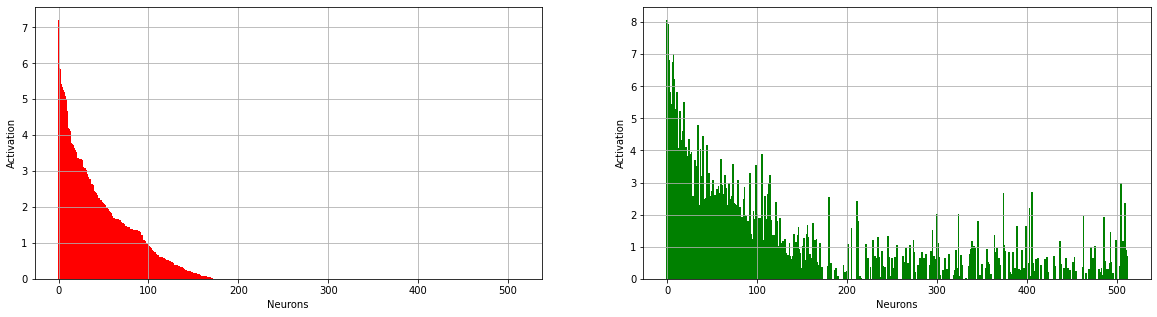

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

X = list(int(i) for i in range(0, 512))

# Initialize the lists for X and Y

fig, axs = plt.subplots(1, 2, figsize=(20,5))

axs[0].set_xlabel("Neurons")
axs[0].set_ylabel("Activation")
axs[1].set_xlabel("Neurons")
axs[1].set_ylabel("Activation")

axs[0].grid()
axs[1].grid()

for i in range(10):
  
  axs[0].bar(X, sorted_adv[i][0:512].cpu(), color = 'r', width=2)
  axs[1].bar(X, tmp2[i][0:512].cpu(), color = 'g', width=2)

# plt.xticks(rotation = 0)
    # plt.savefig('dataset_and_generated_graph/same_resolution/plot'+str(i)+'.png', dpi=500, bbox_inches='tight')
plt.show()

In [ ]:
# Neuron Output
sorted_real_inf, indices_inf = torch.sort(influence_real, descending=True, dim = 1)
print(sorted_real_inf)
print(indices_inf)
# Neuron influence

tensor([[ 126.5609,  120.7464,  110.1906,  ...,  -86.7203,  -92.6551,
         -112.5830],
        [ 227.2492,  223.1650,  185.7258,  ..., -188.3973, -195.8929,
         -253.3550],
        [  98.1361,   76.9497,   65.2764,  ...,  -45.1864,  -50.2923,
          -77.1929],
        ...,
        [ 141.5533,  125.2517,  124.9414,  ..., -142.6230, -142.8018,
         -144.2906],
        [ 214.8104,  199.5241,  190.5963,  ..., -124.4990, -125.4896,
         -139.6186],
        [ 253.4713,  233.3857,  218.7722,  ..., -164.1593, -192.3978,
         -196.4012]])
tensor([[1771, 2835, 2939,  ..., 3947,   10, 2495],
        [2025, 3194, 1953,  ..., 2043,  810,  469],
        [2494, 1681, 4007,  ..., 3122,  297, 3238],
        ...,
        [3194, 1953, 4059,  ..., 3903, 2815, 3657],
        [2080, 2590, 2012,  ...,  349,  156, 3295],
        [ 533, 3139, 2812,  ..., 3712,  980, 3947]])


In [ ]:
tmp_inf = []
for i in range(len(indices_inf)):
  # print(sorted_real[i])
  val = []
  for j in indices_inf[i]:
    value = influence_adv[i][j]
    val.append(value)
  # print(val)  
  tmp_inf.append(torch.FloatTensor(val))
# print(tmp_inf.shape)

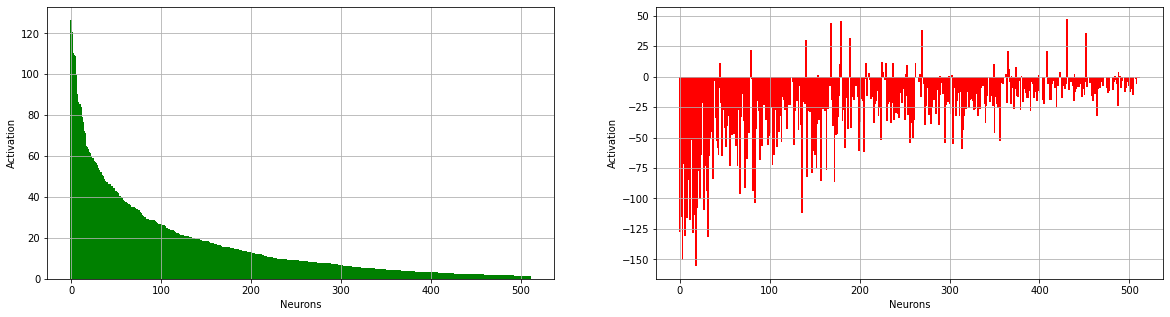

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

X = list(int(i) for i in range(0, 512))

# Initialize the lists for X and Y

fig, axs = plt.subplots(1, 2, figsize=(20,5))

axs[0].set_xlabel("Neurons")
axs[0].set_ylabel("Activation")
axs[1].set_xlabel("Neurons")
axs[1].set_ylabel("Activation")

axs[0].grid()
axs[1].grid()

for i in range(1):
  
  axs[0].bar(X, sorted_real_inf[i][0:512].cpu(), color = 'g', width=2)
  axs[1].bar(X, tmp_inf[i][0:512].cpu(), color = 'r', width=2)

# plt.xticks(rotation = 0)
    # plt.savefig('dataset_and_generated_graph/same_resolution/plot'+str(i)+'.png', dpi=500, bbox_inches='tight')
plt.show()